# Traffic Sign Detection

About the object detection model: <a href='https://github.com/tyasemin/FO-Internship-Project-2/blob/main/notebooks/Object%20Detection.ipynb'>YOLOV4
<br>
<a href='https://github.com/tyasemin/FO-Internship-Project-2/tree/main/traffic_sign_detection'> See the Source Code</a>

The idea is to use the YOLOV4 pre-trained model's weight to train the model for the traffic sign dataset.
With this method, the training phase will be more accurate and fast.

## Dataset Preparation

YOLOV4 model takes training data with a specific format. The dataset must be a .txt file and the content of this file must be class id and bounding box coordinates in order.These coordinates were taken and saved in the above-mentioned format. 

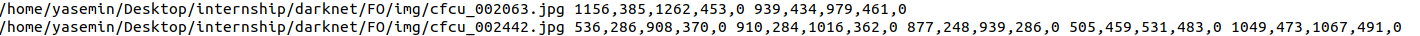

<b>Images and their bounding box tags must be in the same folder, with the same name </b> (different format).For this reason, splitting the train, validation, and test dataset will only be done by separating the paths of the images.

Images without traffic signs were extracted from the dataset and the above code was run again.

<b>I trained the model first on my own computer and then on Colab to take output(flags and OpenCV didn't work for some reason I can't figure out), so the paths of the images needed to be changed for both sides.</b>

Finally, datasets (train, validation, and test) must be look like this(for Colab):

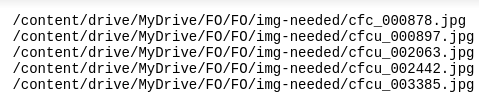

Since YOLOV4 accepts bounding box coordinates in the range 0-1, the coordinates should be as follows after bounding in this range.

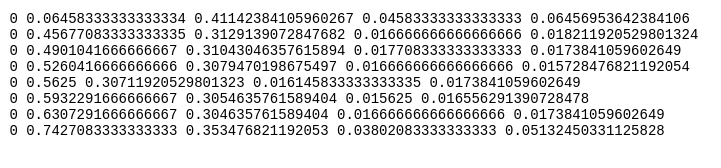

## Training And Testing With Test Data

I trained the model on my own computer for about 3 hours using only GPU.Then I took the last recorded weight and loaded it into Colab and retrained it.The next part is the part I trained at Colab. If you do not have problems with flag and OpenCV, you can use command lines directly.
<br>
If you have problems, you can write command lines by changing the makefile for GPU only and disabling the flags. Then you can continue training on Colab using the last weight.

In [ ]:
#clone darknet to Colab
!git clone https://github.com/AlexeyAB/darknet

The files that need to be created to train the model are as follows:

<b>FO.data:</b>The class number, the path of the datasets and the path for the backup to be saved must be specified.

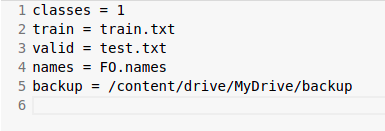

<b>FO.names:</b> The name of the class to be detected must be specified.

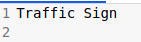

<b>yolov4-FO.cfg:</b>This file is for the YOLOV4 model and it stores settings and configuration information. YOLOV4 has three "yolo" blocks and inside these blocks, there is "classes". It must be changed to 1 on each yolo block.(for Traffic Sign)

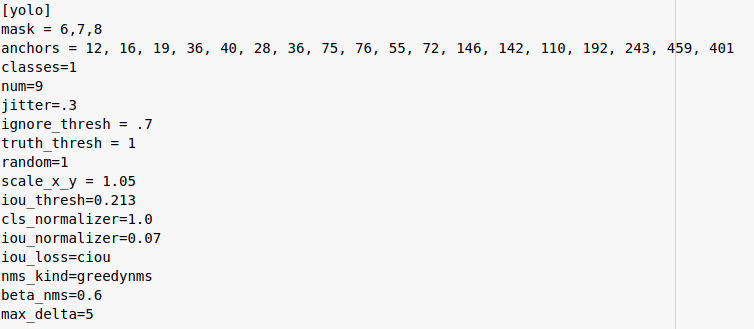

There are also "convolutional" blocks before the "yolo" blocks. In these convolutional blocks, there are "filters" and it must be changed to 18, or the core will crash.
<br>
Formula=(number of classes+5)*3 -> (1+5)*3

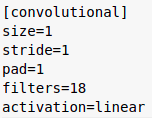

After changing both the filter and the number of classes, the blocks should look like this:

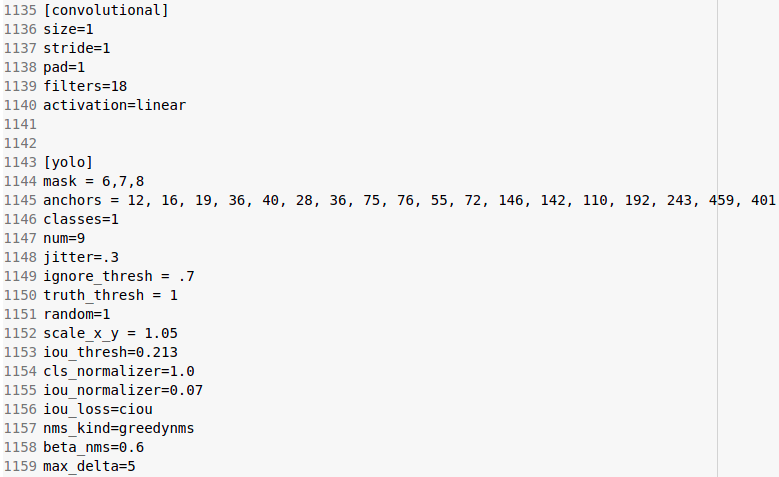

In [ ]:
#Which structures we will use, we should make 1 on the makefile.
#It can also be changed manually in the make file, I'm adding it like this just to show.
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile  
!sed -i 's/GPU=0/GPU=1/' Makefile 
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile 
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

In [ ]:
!make

If training will be started directly on Colab, the pre-trained weights can be downloaded with the following code.

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

I copied the final weights and datasets of the model I trained with pre-trained weights into the darknet.

In [ ]:
#datasets
!cp /content/drive/.../train.txt ./train.txt
!cp /content/drive/.../val.txt ./val.txt
!cp /content/drive/.../test.txt ./test.txt

In [ ]:
#yolov4 files
!cp /content/drive/.../FO.data ./FO.data
!cp /content/drive/.../FO.names ./FO.names
!cp /content/drive/.../yolov4-FO.cfg ./yolov4-FO.cfg
!cp /content/drive/.../yolov4.weights ./yolov4.weights
!cp /content/drive/.../yolov4-FO_900.weights ./yolov4-FO_900.weights
!cp /content/drive/.../yolov4-FO_last.weights ./yolov4-FO_last.weights

In [ ]:
#images and labels
!unzip -d /content/drive/.../FO /content/drive/.../FO.zip

Batch and subdivision values ​​have been changed so that the model can be in the training phase.

In [ ]:
#you can use %%capture or set 32 for batch size and set 8 for subdivisions

!sed -i 's/batch=1/batch=64/' yolov4-FO.cfg
!sed -i 's/subdivisions=1/subdivisions=16' yolov4-FO.cfg

In [ ]:
%%capture
!./darknet detector train FO.data yolov4-FO.cfg yolov4-FO_last.weights -dont_show -map #train the model

Since the IOU value was not enough, I trained it once again.After reaching an IOU and classification value worth testing, the test data is given to the model and its outputs are written to the JSON file.

In [ ]:
!./darknet detector test FO.data yolov4-FO.cfg yolov4-FO_last.weights <test.txt -ext_output -dont_show -out FOModelPrediction.json

Some of the model outputs are as follows:

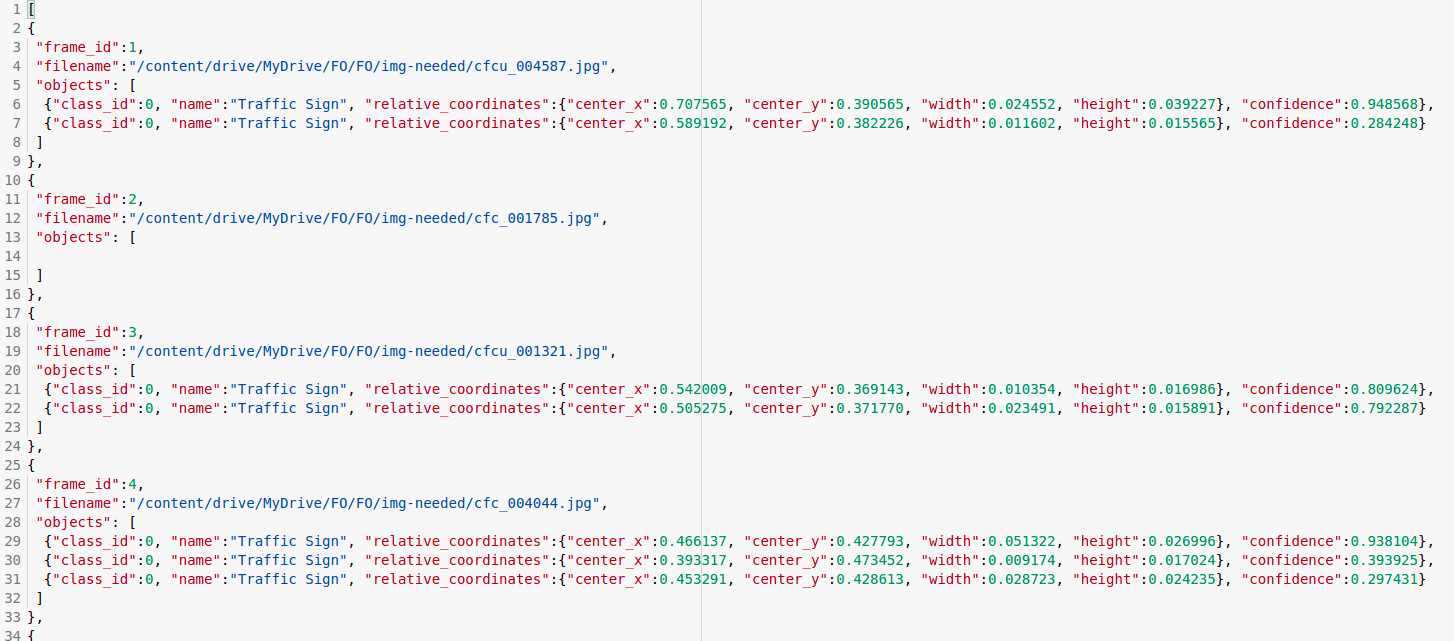

## Visualization

Developed the following code to visualize the outputs of the model:

In [ ]:
import json
import cv2
from matplotlib import pyplot as plt

Function to get coordinates saved in JSON file.

In [ ]:
def return_coordinates(json_obj):
    obj=json_obj['objects']
    coordinate_list=[]
    for bbx in obj:
        coordinates=bbx['relative_coordinates']
        center_x,center_y,width,height=coordinates['center_x'],coordinates['center_y'],coordinates['width'],coordinates['height']
        confidence=bbx['confidence']
        coordinate_list.append((center_x,center_y,width,height,confidence))
    return coordinate_list

In [ ]:
def return_image_path(json_obj):
    path=json_obj['filename']
    return path

The function to get the dimensions of the iamge to be tested since the coordinates are in the range of 0-1 and will be recalculated according to the picture size.

In [ ]:
def return_image_size(img):
      return img.shape[1],img.shape[0]

In [ ]:
def return_image_name(path):
  image_name=path[40:]
  return image_name

Extraction of JSON files added for ground truth.

In [ ]:
!unzip -d /content/drive/MyDrive/model /content/drive/MyDrive/model/annotation.zip

In [ ]:
def return_json_name(img_name):
  JSON_DIR="/content/drive/MyDrive/model/annotation/"
  return JSON_DIR+img_name[:-3]+"png"+".json"

Ground truth coordinates were taken from the JSON file and drawn as a red bounding box on the image.

In [ ]:
def return_GT_image(json_obj,img):
  with open(json_obj,'r') as f:

    jsnfile=json.load(f)
    GT_obj=jsnfile['objects']
    for obj in GT_obj:
      if obj['classTitle']=="Traffic Sign":
        obj_class_pts = obj['points']['exterior']
        x_0=obj_class_pts[0][0]
        y_0=obj_class_pts[0][1]
        x_1=obj_class_pts[1][0]
        y_1=obj_class_pts[1][1]

        cv2.rectangle(img, (int(x_0), int(y_0)), (int(x_1),int(y_1)),
                              color=(0, 0, 255), 
                              thickness=2)
        plt.imshow(img)
    return img

The path to the file where the outputs of the model are saved is defined.

In [ ]:
json_path='/content/drive/MyDrive/model/FOModelPrediction.json'

Then the coordinates predicted by the model were recalculated according to the size of the picture and drawn on the picture with green color.Confidence value in the model's predictions has also been added

In [ ]:
with open(json_path, 'r') as f:
    jsonfile = json.load(f)
    json_obj=jsonfile

ground_path="/content/drive/MyDrive/GT/"
final_path="/content/drive/MyDrive/final/"
#prediction_path="/content/drive/MyDrive/prediction/"
i=0
for obj in json_obj:

  img_path=return_image_path(obj)
  coordinates=return_coordinates(obj)
  img=cv2.imread(img_path)
  #ground
  img_name=return_image_name(img_path)
  GT_json=return_json_name(img_name)
  GT_img=return_GT_image(GT_json,img) 
  #ground

  img_1,img_0=return_image_size(img)
  
  #draw predictions
  for bbx in coordinates: 
    xcenter,ycenter,width,height,confidence=bbx

    xcenter=xcenter*img_1
    ycenter=ycenter*img_0

    width=width*img_1
    height=height*img_0

    x_min=abs(xcenter-(width/2))
    y_min=abs(ycenter-(height/2))

    x_max=width+x_min
    y_max=height+y_min

    w=int(width)
    h=int(height)

    cv2.rectangle(img, (int(x_min+w), int(y_min+h)), (int(x_min),int(y_min)),
                              color=(0, 255, 0), 
                              thickness=2)
    cv2.putText(img, 'Traffic Sign', (int(x_min+50), int(y_min)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    cv2.putText(img,str(int(confidence*100))+str('%'), (int(x_min)-10, int(y_min)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)
    
    i+=1
  
  cv2.imwrite(final_path+str(i)+".jpg",img)

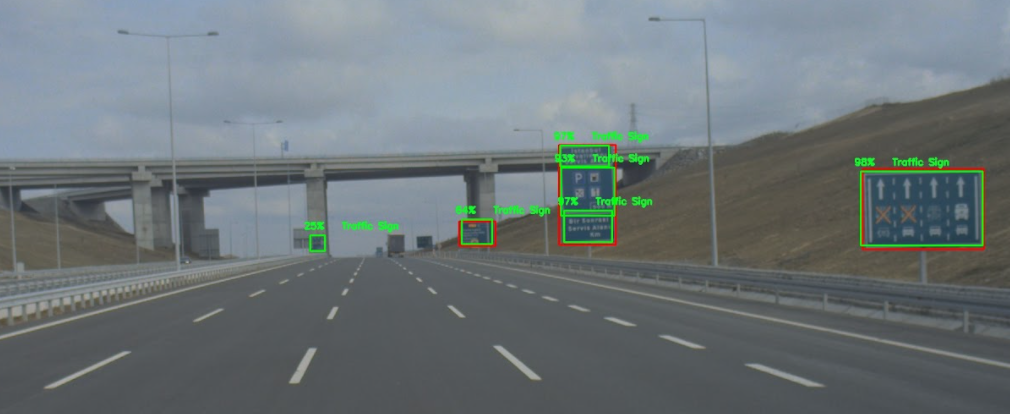

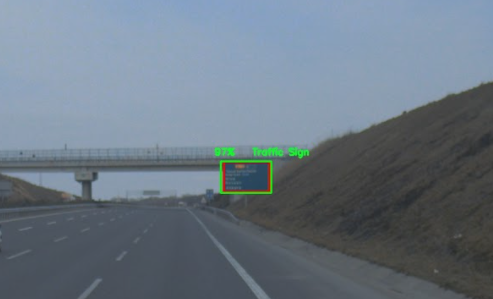

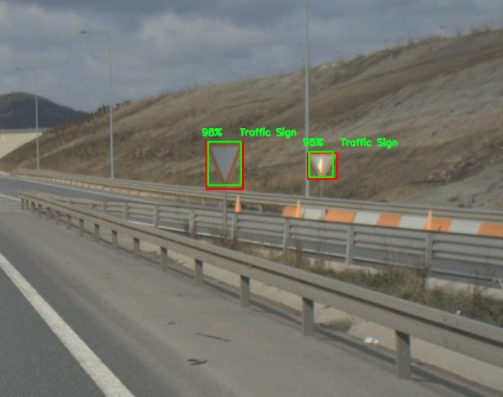